<a href="https://colab.research.google.com/github/chupvl/gcolab/blob/main/2024_05_11_ez_qsar_model_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A very easy introduction into model building for chemistry
by Vladimir Chupakhin

## Packages

In [1]:
!pip install rdkit catboost

## Libs & functions

In [2]:
import pandas as pd
from tqdm import tqdm
import scipy

from sklearn.model_selection import KFold
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr
import numpy as np

In [3]:
import rdkit
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.MolStandardize import rdMolStandardize

from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import Descriptors
# not the best solution but rdkit is chatty (for good, not bad)
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')



In [4]:
def mol_std(smiles):
  try:
    # we need rdkit mol format
    m = Chem.MolFromSmiles(smiles)
    # default cleaning procedure
    m = rdMolStandardize.Cleanup(m)
    # getting the largest compound
    m = rdMolStandardize.FragmentParent(m)
    # removing charge if any
    uncharger = rdMolStandardize.Uncharger()
    m = uncharger.uncharge(m)
    # this is the most controversional step
    # getting the most common tautomeric form
    # and the main source of errors
    TautomerEnumerator = rdMolStandardize.TautomerEnumerator()
    m = TautomerEnumerator.Canonicalize(m)
    return m
  except:
    return None

In [5]:
def getRDKitDescr(lst_mols):
    # physchem and 1D descriptors
    descriptor_names = [d[0] for d in Descriptors.descList]
    descriptor_funcs = [d[1] for d in Descriptors.descList]
    # init matrix
    fp_matrix = scipy.sparse.lil_matrix((len(lst_mols), 2048))
    #
    descr2d_lst = []
    # calculate descriptors
    for i, mol in tqdm(enumerate(lst_mols)):
        try:
            # let's use Morgan one
            fp = rdFingerprintGenerator.GetMorganGenerator(radius=3).GetFingerprint(mol)
            for j in fp.GetOnBits():
                fp_matrix[i, j] = 1
            descr2d = {desc_name: func(mol) for desc_name, func in zip(descriptor_names, descriptor_funcs)}
            descr2d_lst.append(descr2d)
        except:
            descr2d_lst.append(None)
            continue
    # sparse format will let you save memory and disk space
    descr_rdkit_2d = scipy.sparse.csr_matrix(pd.DataFrame(descr2d_lst).to_numpy())
    descr_combo = scipy.sparse.hstack((descr_rdkit_2d, fp_matrix))
    descr_names = descriptor_names + [['FP'+'str(i)']*2048 for i in range(2048)]
    return descr_combo, descr_names


In [6]:
def run_cb(X,y):
  # CatBoostRegressor
  model = CatBoostRegressor(loss_function='RMSEWithUncertainty', verbose=False)
  # K-fold cross-validation
  kf = KFold(n_splits=5, shuffle=True, random_state=42)

  rmse_scores = []
  r2_scores = []
  spearman_scores = []

  # cross-validation
  for train_index, test_index in kf.split(X):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y[train_index], y[test_index]

      train_pool = Pool(X_train, y_train)
      test_pool = Pool(X_test, y_test)

      model.fit(train_pool, eval_set=test_pool)

      y_pred = model.predict(X_test)
      y_pred_mean = y_pred[:, 0]

      # Calculate metrics
      rmse = np.sqrt(mean_squared_error(y_test, y_pred_mean))
      r2 = r2_score(y_test, y_pred_mean)
      spearman_corr, _ = spearmanr(y_test, y_pred_mean)

      rmse_scores.append(rmse)
      r2_scores.append(r2)
      spearman_scores.append(spearman_corr)

  print("Median RMSE:", np.median(rmse_scores))
  print("Median R²:", np.median(r2_scores))
  print("Median Spearman Correlation:", np.median(spearman_scores))
  res = {}
  res['model'] = model
  res['rmse_scores'] = rmse_scores
  res['r2_scores'] = r2_scores
  res['spearman_scores'] = spearman_scores
  return res

## Data

Let's use the most simple example of water solubility prediction.
We will take the dataset from Oleg A. Raevsky [publication](https://pubs.acs.org/doi/10.1021/ci400692n) that was curated as a part of the [AqSol database](https://www.nature.com/articles/s41597-019-0151-1). Why? Those compounds are neutral in water at a standard temperature (25C), thus likely will cause least issues.

In [7]:
#
df = pd.read_csv('https://raw.githubusercontent.com/mcsorkun/AqSolDB/master/results/data_curated.csv')
#
dfc = df[df['ID'].str.contains('C-')]
dfcg1 = dfc[dfc['Group'] == 'G1'].reset_index(drop=True)

In [8]:
dfc.columns

Index(['ID', 'Name', 'InChI', 'InChIKey', 'SMILES', 'Solubility', 'SD',
       'Occurrences', 'Group', 'MolWt', 'MolLogP', 'MolMR', 'HeavyAtomCount',
       'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds',
       'NumValenceElectrons', 'NumAromaticRings', 'NumSaturatedRings',
       'NumAliphaticRings', 'RingCount', 'TPSA', 'LabuteASA', 'BalabanJ',
       'BertzCT'],
      dtype='object')

Next "curation" step is a selection of the compounds that has most stable solubility values: "The selection is performed by first classifying the compounds into five distinct groups which are defined based on the statistics of occurrence of a compound in the dataset"[ref](https://www.nature.com/articles/s41597-019-0151-1).

In [9]:
df['Group'].value_counts()

Group
G1    7746
G3    1182
G5     636
G2     235
G4     183
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

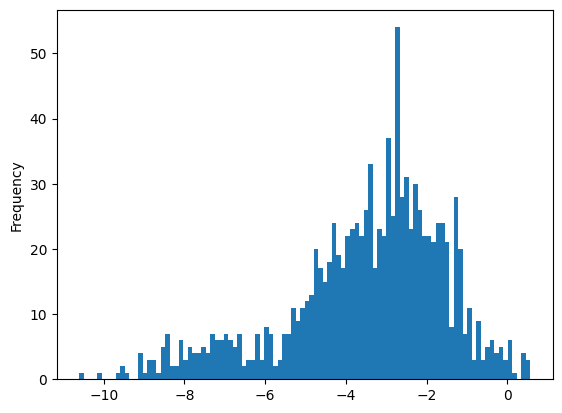

In [10]:
dfcg1['Solubility'].plot(kind='hist', bins=100)

## Smiles standardization

It's common that for open (public) data we deal with data coming from several data sources. Thus SMILES reprsentation might following different encoding rules, as not all vendors of chemsoftware follow identical rules. Standardization procedure is well described [here](https://www.blopig.com/blog/2022/05/molecular-standardization/) and [here](https://github.com/rdkit/rdkit/blob/master/Docs/Notebooks/MolStandardize.ipynb).

In [11]:
result = [mol_std(s) for s in tqdm(dfcg1['SMILES'].to_list())]

100%|██████████| 1073/1073 [01:00<00:00, 17.72it/s]


In [12]:
dfcg1['smiles_std'] = result

## Featurization

In [13]:
descr, descr_names = getRDKitDescr(dfcg1['smiles_std'].to_list())

1073it [00:14, 72.02it/s]


## Modeling building

Catboost models are perfect out-of-box solution for classification and regression. So, we will use cross-validation setup. Most importantly you don't need to bother about descriptor scaling or any other transformation.

In [14]:
X = descr
y = dfcg1['Solubility'].to_numpy()

In [15]:
# catboost does not support sparse by default, so we need to use pandas sparse dataframe
df_descr = pd.DataFrame.sparse.from_spmatrix(descr)
df_descr.head()

,0,1,2,3,4,5,6,7,8,9,...,2248,2249,2250,2251,2252,2253,2254,2255,2256,2257
0,9.903750,9.903750,0.363426,-0.695648,0.579480,9.375000,117.148,106.060,117.078979,48.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9.487593,9.487593,0.231065,-0.231065,0.571409,31.363636,152.237,136.109,152.120115,62.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,10.014931,10.014931,0.452546,-0.724537,0.511678,10.875000,117.148,106.060,117.078979,48.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10.172060,10.172060,0.646991,-1.018519,0.488091,15.111111,149.215,138.127,149.051050,54.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11.858935,11.858935,0.030000,-0.738426,0.652158,27.153846,183.251,166.115,183.125929,74.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# different loss metrics will impact the model quality
# but let's use RMSEWith
aqsol_model = run_cb(df_descr, y)

Median RMSE: 0.9382356930630592
Median R²: 0.7882259242285613
Median Spearman Correlation: 0.8407696341453892


No the perfect model, but can be used as a baseline.
There are many ways to improve the quality, but that's a totally different story.

<Axes: xlabel='Solubility', ylabel='y_pred'>

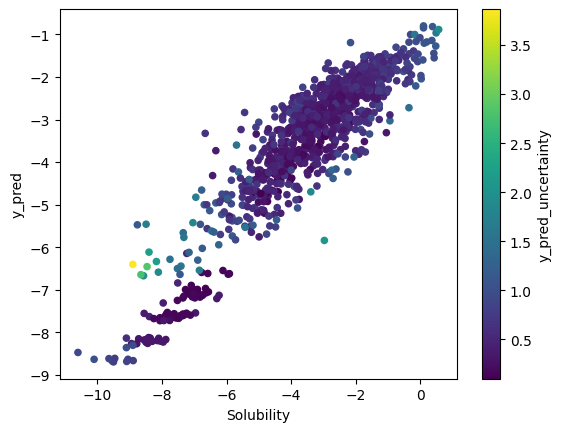

In [23]:
# picture worth a 1000 words, right...
y_pred = aqsol_model['model'].predict(df_descr)
dfcg1['y_pred'] = y_pred[:,0]
dfcg1['y_pred_uncertainty'] = y_pred[:,1]
dfcg1.plot(x='Solubility', y='y_pred', c='y_pred_uncertainty', kind='scatter')